In [13]:
import qibo
from qibo import Circuit, gates
from qibo import hamiltonians
from qibo.symbols import X, Y, Z, I
from qibo.noise import NoiseModel, PauliError, DepolarizingError
from qibo.result import MeasurementOutcomes
import numpy as np
from numpy.random import choice
import time
import matplotlib.pyplot as plt
from scipy.linalg import expm, logm
from scipy.optimize import minimize
from scipy.special import comb
from itertools import combinations
import multiprocessing
from math import pi
qibo.set_backend("numpy")
from numpy.linalg import eigh

[Qibo 0.2.3|INFO|2024-01-10 13:54:59]: Using numpy backend on /CPU:0


In [14]:
time_start = time.time()
n_qubit = 4
a = 1
mass = 5
g = 1

pauli_x = np.array([[0,1],[1,0]]) # Pauli matrix
pauli_y = np.array([[0,-1j],[1j,0]])
pauli_z = np.array([[1,0],[0,-1]])

哈密顿量

In [15]:
# NJL: 1+1 D
# define interaction form
def phidaggerphi(position_i,position_j):
    if position_i==position_j:
        res = (I(position_i) + Z(position_i))/2
    elif position_i > position_j:
        res = (X(position_i) + 1j*Y(position_i)) * (X(position_j) - 1j*Y(position_j)) *(1j) /4
        for k in range(position_j+1,position_i):
            res *= 1j * Z(k)
    elif position_i< position_j:
        res = (X(position_i) + 1j*Y(position_i)) * (X(position_j) - 1j*Y(position_j)) *(-1j) /4
        for k in range(position_i+1,position_j):
            res *= -1j * Z(k)
    return res

# 具体构造哈密顿量
H1 = 0
for n in range(n_qubit-1):
    H1 += phidaggerphi(n,n+1) - phidaggerphi(n+1,n)
H1 += phidaggerphi(n_qubit-1,0) - phidaggerphi(0,n_qubit-1)
H1 *= -1j/(2*a)

H2 = 0
for n in range(n_qubit):
    H2 += (-1)**n * phidaggerphi(n,n)
H2 *= mass

H3 = 0 # 先空间点内求和，然后平方，再空间点求和
for n in range(int(n_qubit/2)): # 遍历空间坐标
    temp = 0
    for i in range(2): # 遍历空间坐标内
        temp += (-1)**i * phidaggerphi(2*n+i,2*n+i)
    H3 += temp * temp
H3 *= -g/a

H_form = H1 + H2 + H3
print(H_form)
ham = hamiltonians.SymbolicHamiltonian(H_form)
del(n)

-1.0*(((I0 + Z0)/2 - (I1 + Z1)/2)**2 + ((I2 + Z2)/2 - (I3 + Z3)/2)**2) + 5*((I0 + Z0)/2 - (I1 + Z1)/2 + (I2 + Z2)/2 - (I3 + Z3)/2) - 0.5*I*(-0.25*I*(X0 + 1.0*I*Y0)*(X1 - 1.0*I*Y1) - 0.25*I*(X0 + 1.0*I*Y0)*(X3 - 1.0*I*Y3)*Z1*Z2 - 0.25*I*(X1 + 1.0*I*Y1)*(X0 - 1.0*I*Y0) - 0.25*I*(X1 + 1.0*I*Y1)*(X2 - 1.0*I*Y2) - 0.25*I*(X2 + 1.0*I*Y2)*(X1 - 1.0*I*Y1) - 0.25*I*(X2 + 1.0*I*Y2)*(X3 - 1.0*I*Y3) - 0.25*I*(X3 + 1.0*I*Y3)*(X0 - 1.0*I*Y0)*Z1*Z2 - 0.25*I*(X3 + 1.0*I*Y3)*(X2 - 1.0*I*Y2))


能量本征值

In [16]:
ham.eigenvalues()

[Qibo 0.2.3|WARNING|2024-01-10 13:54:59]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


array([-1.20909063e+01, -6.09901951e+00, -6.09901951e+00, -6.00000000e+00,
       -6.00000000e+00, -2.00493818e+00, -2.00000000e+00, -1.52574358e-02,
        0.00000000e+00,  0.00000000e+00,  1.45034735e-16,  4.00000000e+00,
        4.00000000e+00,  4.09901951e+00,  4.09901951e+00,  8.11110193e+00])

线路

In [5]:
# 随机翻转线路
def circ_random_flip(circuit,n_flip):
    """抽取不相同的随机n_flip个qbit翻转"""
    temp = list(range(n_qubit))
    flip_index = np.random.choice(a=temp,size=n_flip,replace=False)
    for i in flip_index:
        circuit.add(gates.X(i))
    flip_index = list(np.zeros(n_flip))
    flip_index.sort() # 排序
    print('flip qubit index:', flip_index)

# initial state in computer basis
def circ_initial_state(circuit, index:int):
    if index > 2**n_qubit:
        print('initial state index error, out of maximum')
    else:
        temp_index = index
        temp_str = ''
        for i in range(n_qubit):
            temp_str += str(temp_index%2)
            temp_index = int(temp_index/2)
        # print('initial state:',temp_str)
        for i in range(n_qubit):
            if temp_str[i]=='1':
                circuit.add(gates.X(i))

# exp(sigma_I)
# 任意pauli string 的 exp 算符
def circ_exp_PS(circuit, pauli_string, theta):
    """exp[-i delta_beta a_mu simga^mu]"""
    for i in range(n_qubit): # 遍历所有qubit
        temp = pauli_string[i]
        if temp=='I':  # 前后加入门
            circuit.add(gates.Z(i))
        elif temp=='x':
            circuit.add(gates.H(i))
        elif temp=='y':
            circuit.add(gates.RX(q=i,theta=pi/2))

    for i in range(n_qubit-1): # 加入CNOT门
        circuit.add(gates.CNOT(i,n_qubit-1))
    circuit.add(gates.RZ(q=n_qubit-1,theta=theta))
    for i in range (n_qubit-1): # 第二次添加CNOT门
        temp = n_qubit-2 - i
        circuit.add(gates.CNOT(temp,n_qubit-1))
    
    for i in range(n_qubit): # 遍历所有qubit
        temp = pauli_string[i]
        if temp=='x':
            circuit.add(gates.H(i))
        elif temp=='y':
            circuit.add(gates.RX(q=i,theta=-pi/2))

def circ_M(circuit):
    for n in range(n_qubit):
        circuit.add(gates.M(n))

表象变换矩阵U

In [6]:
# 线路U
def map_PS(string:str,position):
    """输入一个短的pauli string，和短pauli string的起始位置，补全剩下的单位算符和自动将超出n_qubit的字符替换掉最前面的单位算符，返回数据类型为str"""
    if len(string)<=n_qubit:
        temp = ''
        for i in range(n_qubit):
            temp += 'I'

        temp_list = list(temp)
        for i in range(len(string)):
            if position+i<=n_qubit-1:
                temp_list[position+i] = string[i]
            elif position+i > n_qubit-1:
                temp_list[position+i-n_qubit] = string[i]
        res = ''.join(temp_list)
        # print('pauli string:',res)
        return res
    else:
        print('pauli string lenth large than n_qubit')


# 表象变换矩阵
# Unitary Quantum Neural Network
def circ_U(circuit,alpha,layers):
    """U为表象变换矩阵，其中alpha为U参数（大小为3*n_qubuit），alpha的大小为3*n_qubit*layers"""
    for l in range(layers):
        for i in range(n_qubit): # 遍历所有qubit
            temp_PS = map_PS(string='x',position=i)
            circ_exp_PS(circuit=circuit, pauli_string=temp_PS, theta=alpha[3*l+i])
            temp_PS = map_PS(string='z',position=i)
            circ_exp_PS(circuit=circuit, pauli_string=temp_PS, theta=alpha[3*l+n_qubit+i])
            temp_PS = map_PS(string='zz',position=i)
            circ_exp_PS(circuit=circuit, pauli_string=temp_PS,theta=alpha[3*l+2*n_qubit+i])

VQE

In [7]:
class VQE(object):
    def __init__(self,temperature,layers,n_flip):
        """本类里面的theta是E_i前面的系数，alpha是线路参数"""
        self.temperature = temperature
        self.layers = layers
        self.n_flip = n_flip

    def temp_circ(self,circuit,alpha,flip_index:list):
        """计算的基本线路，得到最终结果需要多个基本线路通过一定比例混合而成"""
        circ_initial_state(circuit=circuit,index=10) # 初始010101
        for i in flip_index:
            circuit.add(gate=gates.X(i))
        circ_U(circuit=circuit,alpha=alpha,layers=self.layers)
    
    def theta_energy_entropy(self,alpha):
        """返回三个值，第一个是theta_list，第二个是能量，第三个是熵"""
        energy = 0
        entropy = 0
        theta_list = []
        qubit_list = list(range(n_qubit))
        for f in range(self.n_flip): # 例：n_flip=2，选取|0101>+所有翻转1个的初态
            temp = list(combinations(qubit_list,f)) # 制备所有可能的翻转可能
            for n in temp: # 具体翻转哪几个qubit
                circ = Circuit(nqubits=n_qubit,density_matrix=False)
                self.temp_circ(circuit=circ,alpha=alpha,flip_index=n)
                state = circ.execute().state()
                E_i = ham.expectation(state=state) # E_i

                theta_i = np.exp(-E_i/self.temperature) # 没有归一化的theta
                theta_list.append(theta_i)
                energy += E_i * theta_i
        normal = sum(theta_list) # 归一化
        energy = energy/normal
        theta_list = theta_list/normal
        for theta in theta_list:
            entropy -= theta * np.log(theta)
        return theta_list,energy,entropy
    
    def free_energy(self,alpha):
        theta_list,energy,entropy = self.theta_energy_entropy(alpha=alpha)
        return energy - self.temperature * entropy
    
    def thermal_state(self,alpha):
        """返回热态（密度矩阵）：rho = sum_i theta_i U | phi_i > < phi_i | Udagger """
        theta,energy,entropy = self.theta_energy_entropy(alpha=alpha)
        qubit_list = list(range(n_qubit))
        res = 0
        theta_index = 0
        for f in range(self.n_flip): # 例：n_flip=2，选取|0101>+所有翻转1个的初态
            temp = list(combinations(qubit_list,f)) # 制备所有可能的翻转组合
            for n in temp: # 具体翻转哪几个qubit
                circ = Circuit(nqubits=n_qubit,density_matrix=True)
                self.temp_circ(circuit=circ,alpha=alpha,flip_index=n)
                res += theta[theta_index]*(circ().state())
                theta_index += 1
        return res
    
    def Opt(self,n_Opt): # 最小化自由能
        """n_Opt：优化次数，取最好的优化结果"""
        Opt_params = np.random.random(3*n_qubit*self.layers)
        Opt_res = minimize(fun=self.free_energy,x0=Opt_params,method='BFGS',tol=1e-03)
        print('free energy=',Opt_res.fun)
        for i in range(1,n_Opt):
            print('Opt:',i)
            Opt_params = np.random.random(3*n_qubit*self.layers)
            temp_res = minimize(fun=self.free_energy,x0=Opt_params,method='BFGS',tol=1e-03)
            if Opt_res.fun-temp_res.fun>1e-05:
                print('Opt update:free energy=',temp_res.fun)
                Opt_res = temp_res
        print(Opt_res.message,Opt_res.fun)
        return Opt_res


优化

In [8]:
# VQE 优化
layers = 4
n_flip = 1
n_Opt = 10
temperature_list = [0.1,0.3,0.5,0.7,0.9,1.1,1.3,1.5,1.7,1.9,2.1,2.3,2.5,3,3.5]
Opt_res = VQE(temperature=temperature_list[len(temperature_list)-1],layers=layers,n_flip=n_flip).Opt(n_Opt=n_Opt)

free energy= -11.999998526678715
Opt: 1
Opt: 2
Opt: 3
Opt: 4
Opt: 5
Opt: 6
Opt: 7
Opt: 8
Opt: 9
Optimization terminated successfully. -11.999998526678715


熵 & 自由能

ED entropy: [(-4.085578092987106e-17-1.646691463619561e-17j), (1.5368782663457273e-07-2.8305723034073164e-23j), (0.0002972851490025889-0j), (0.006906908753339008-4.6095120432094207e-26j), (0.037782308995108926-0j), (0.1083124082786497-0j), (0.22020246815281386-0j), (0.36481843965966276-0j), (0.5297866379258401-0j), (0.7033832671288586-0j), (0.8764358464197433-0j), (1.0426677458635618-0j), (1.1983102791485072-0j), (1.531859123396769-0j), (1.788425244395501-0j)]
p_ED entropy: [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]
[(-12.090906314992784+1.646691463619561e-18j), (-12.090906317176781+8.491716910221949e-24j), (-12.09091768416148+0j), (-12.091408223790662+3.2266584302465943e-26j), (-12.09530741845346+0j), (-12.10919969641235+0j), (-12.141413081521627+0j), (-12.19946995033391+0j), (-12.288695141431777+0j), (-12.411953763011864+0j), (-12.570005563556826+0j), (-12.76206776678541+0j), (-12.986362509563508+0j), (-13.6722870677623+0j), (-14.505313

c:\Users\yansh\miniconda3\envs\qibo\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:836: LogmNearlySingularWarning: The logm input matrix may be nearly singular.
  warnings.warn(near_singularity_msg, LogmNearlySingularWarning)
c:\Users\yansh\miniconda3\envs\qibo\lib\site-packages\matplotlib\cbook\__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


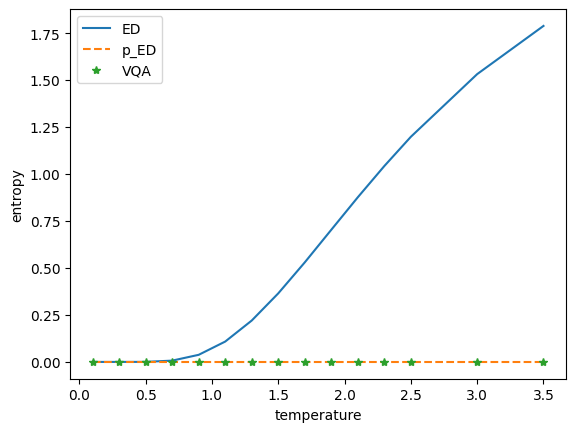

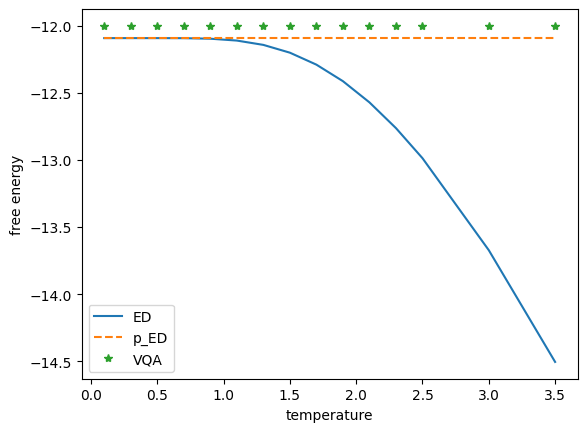

In [9]:
# 精确对角化取部分哈密顿量
def portion_ham(n_flip):
    temp = ham.eigenvalues()
    n_state = 0
    for i in range(n_flip):
        n_state += comb(n_qubit,i)
    n_state = int(n_state)
    res = np.zeros((n_state,n_state))
    for i in range(n_state):
        res[i,i] = temp[i]
    return res

# 精确对角化熵
def ED_entropy(temperature,H):
    rho = expm(-H/temperature)
    rho = rho/np.trace(rho)
    return -np.trace(np.dot(rho,logm(rho)))

# 精确对角化自由能
def ED_free_energy(temperature,H):
    rho = expm(-H/temperature)
    rho = rho/np.trace(rho)
    E = np.trace(np.dot(H,rho))
    S = -np.trace(np.dot(rho,logm(rho)))
    return E - temperature * S

# ED entropy
ED_entropy_list = []
for t in temperature_list:
    ED_entropy_list.append(ED_entropy(temperature=t,H=ham.matrix))
print('ED entropy:',ED_entropy_list)

# portion entropy
portion_entropy_list = []
for t in temperature_list:
    portion_entropy_list.append(ED_entropy(temperature=t,H=portion_ham(n_flip=n_flip)))
print('p_ED entropy:',portion_entropy_list)

# ED free energy
ED_free_energy_list = []
for t in temperature_list:
    ED_free_energy_list.append(ED_free_energy(temperature=t,H=ham.matrix))
print(ED_free_energy_list)

# portion free energy
portion_free_energy_list = []
for t in temperature_list:
    portion_free_energy_list.append(ED_free_energy(temperature=t,H=portion_ham(n_flip=n_flip)))
print(portion_free_energy_list)

# VQE
entropy_list = []
free_energy_list = []
for t in temperature_list:
    theta_list,energy,entropy = VQE(temperature=t,layers=layers,n_flip=n_flip).theta_energy_entropy(alpha=Opt_res.x)
    entropy_list.append(entropy)
    free_energy_list.append(energy-t*entropy)

plt.figure()
# plt.xlim(0,max(temperature_list))
# plt.ylim(0,max(ED_entropy_list))
plt.plot(temperature_list,ED_entropy_list,label='ED')
plt.plot(temperature_list,portion_entropy_list,'--',label='p_ED')
plt.plot(temperature_list,entropy_list,'*',label='VQA')
plt.xlabel('temperature')
plt.ylabel('entropy')
plt.legend()

plt.figure()
# plt.xlim(0,max(temperature_list))
# plt.ylim(0,max(ED_free_energy_list))
plt.plot(temperature_list,ED_free_energy_list,label='ED')
plt.plot(temperature_list,portion_free_energy_list,'--',label='p_ED')
plt.plot(temperature_list,free_energy_list,'*',label='VQA')
plt.xlabel('temperature')
plt.ylabel('free energy')
plt.legend()

对比两个热态之间的差别

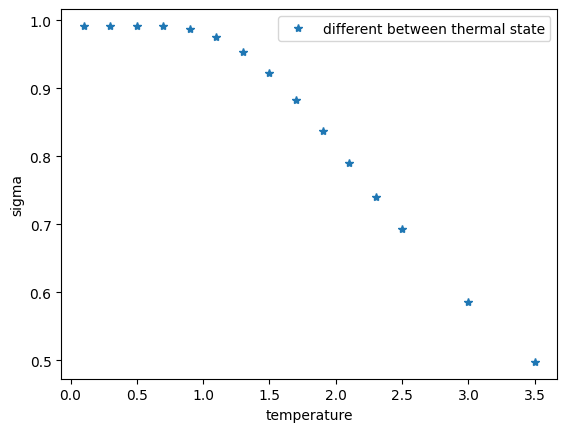

In [10]:
def rho(temperature):
    res = expm(-ham.matrix/temperature)
    res = res/np.trace(res)
    return res

rd_list = []
for t in temperature_list:
    ts = VQE(temperature=t,layers=layers,n_flip=n_flip).thermal_state(alpha=Opt_res.x)
    rd_list.append(np.trace(np.dot(rho(t),ts)))

#画图
plt.figure()
plt.plot(temperature_list,rd_list,'*',label='different between thermal state')
plt.xlabel('temperature')
plt.ylabel('sigma')
plt.legend()

sigma凝聚

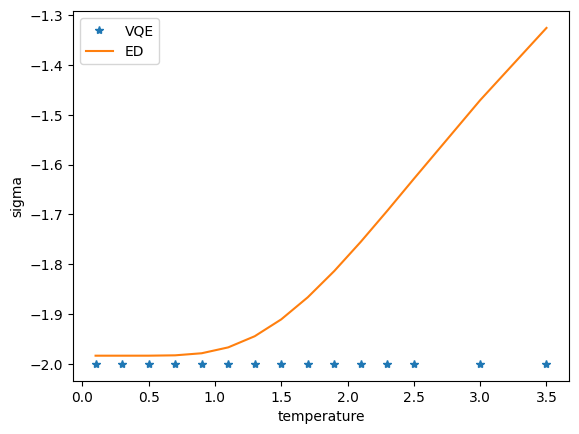

In [11]:
def sigma_form(position): # 每个空间点的sigma算符
    if position>=int(n_qubit/2) or position<0:
        print('wrong positon')
    else:
        res = (-1)**(2*position) * phidaggerphi(2*position,2*position) + (-1)**(2*position+1) * phidaggerphi(2*position+1,2*position+1)
        return res
    
# 全空间求和的sigma
sigma_F = 0
for n in range(int(n_qubit/2)): # 空间点求和
    sigma_F += sigma_form(position=n)
sigma = hamiltonians.SymbolicHamiltonian(sigma_F)

# ED
ED_sigma_list = []
for t in temperature_list:
    rho = expm(-ham.matrix/t)
    rho = rho/np.trace(rho)
    ED_sigma_list.append(sigma.expectation(rho))

# VQE
sigma_list = []
for t in temperature_list:
    rho = VQE(temperature=t,layers=layers,n_flip=n_flip).thermal_state(alpha=Opt_res.x)
    sigma_list.append(sigma.expectation(rho))

#画图
plt.figure()
plt.plot(temperature_list,sigma_list,'*',label='VQE')
plt.plot(temperature_list,ED_sigma_list,label='ED')
plt.xlabel('temperature')
plt.ylabel('sigma')
plt.legend()

计算总时间

In [12]:
time_end = time.time()
print(time_end - time_start)

290.5135018825531
